# Space Charge on the GPU

PyHEADTAIL offers space charge models which are accelerated on graphics processing units (GPUs).

Space charge refers to the impact of the beam's self-fields on itself. In PyHEADTAIL, we model space charge by lumped kicks, which are applied after each tracking segment. The kicks correspond to the integrated space charge effect over the tracked segment's length.

In the present notebook we demonstrate the transverse defocussing effect of space charge. The corresponding detuning over a revolution is modelled with two different approaches:

1. frozen Gaussian field map
2. self-consistent field solving

The first method assumes a fixed Gaussian beam distribution: the actually tracked beam then moves like test particles through the correspondingly generated fields. The second method solves for the fields generated by the particle distribution at each interaction point. 

For a more in-depth discussion of the two methods, you may refer to http://frs.web.cern.ch/frs/Source/space_charge/Meetings/meeting98_17.08.2017/oeftiger_sc_modelling.pdf .

Note that this tutorial requires a GPU with the NVIDIA `CUDA` suite and the python package `PyCUDA` installed.

-- 2017, Adrian Oeftiger

## general imports

In [1]:
from __future__ import division, print_function

import numpy as np
np.random.seed(42)

from scipy.constants import c, epsilon_0, e, m_p

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# sets the PyHEADTAIL directory etc.
try:
    from settings import *
except:
    pass

## PyHEADTAIL imports

In [3]:
from pycuda.autoinit import context
from pycuda import gpuarray as gp

import pycuda.compiler
pycuda.compiler.DEFAULT_NVCC_FLAGS += ['-Wno-deprecated-gpu-targets']

In [4]:
from PyHEADTAIL.particles.slicing import UniformBinSlicer
from PyHEADTAIL.field_maps.field_map import FieldMap, FieldMapSliceWise
from PyHEADTAIL.spacecharge.spacecharge import TransverseGaussianSpaceCharge
from PyHEADTAIL.spacecharge.pypic_factory import create_mesh, create_3dmesh_from_beam
from PyHEADTAIL.spacecharge.pypic_spacecharge import FrozenGaussianSpaceCharge25D
from PyHEADTAIL.particles.rfbucket_matching import RFBucketMatcher

from PyHEADTAIL.general.printers import SilentPrinter
from PyHEADTAIL.general.contextmanager import GPU

PyHEADTAIL v1.12.4.7


Shared libraries of Fortran versions of m2p/p2m (rhocompute, int_field_for, int_field_for_border) not found. Limited functionality


In [5]:
from PyHEADTAIL.spacecharge.pypic_spacecharge import SpaceChargePIC

In [6]:
from PyCERNmachines.CERNmachines import SPS

The `PyPIC.GPU` library for the particle-in-cell algorithm in `PyHEADTAIL` can be installed from https://github.com/PyCOMPLETE/PyPIC:

In [7]:
from PyPIC.GPU.poisson_solver.FFT_solver import GPUFFTPoissonSolver_2_5D
from PyPIC.GPU.pypic import PyPIC_GPU

# not necessary but nice: memory pool sharing between PyHEADTAIL and PyPIC
try:
    from PyHEADTAIL.gpu.gpu_utils import memory_pool
except:
    memory_pool = None

## Setting up the machine and functions

In [8]:
import time

timing_fct = time.time #time.clock

class Timer:
    '''Used for timing purposes. Possibly use
    https://docs.python.org/dev/library/contextlib.html
    #contextlib.ContextDecorator .
    '''
    def __enter__(self):
        self.start = timing_fct()
        return self

    def __exit__(self, *args):
        self.end = timing_fct()
        self.interval = self.end - self.start

In [9]:
n_macroparticles = int(1e6)
n_slices_sc = 32

# fixed field map for space charge
n_mesh_nodes = 1024
n_mesh_sigma = 6

# self-consistent PIC solving for space charge
n_mesh_nodes_pic = 128
n_mesh_sigma_pic = 5

intensity = 1.3e11
epsn_x = epsn_y = 2e-6 # in [m.rad]
sigma_z = 0.23 # in [m]

In [10]:
def make_machine(n_segments=100):
    return SPS(n_segments=n_segments,
               machine_configuration='Q20-injection',
               optics='smooth',
               printer=SilentPrinter(),
               Q_x=20.24,
               Q_y=20.31,
              )

def make_beam(machine=make_machine()):
    return machine.generate_6D_Gaussian_bunch_matched(
        n_macroparticles, intensity, epsn_x, epsn_y, sigma_z)

In [11]:
m = make_machine()
beam = make_beam(m)

sig_x = beam.sigma_x()
sig_y = beam.sigma_y()

slicing_interval = m.longitudinal_map.get_bucket(beam).interval

slicer_sc = UniformBinSlicer(n_slices_sc, z_cuts=slicing_interval)

*** PyHEADTAIL WARNING! RFBucketMatcher: failed to converge with Brent method, continuing with Newton-Raphson method.


## Let's Go!

Before we extract the incoherent space charge detuning from the two different simulations approaches, we compute the theoretically expected tune spreads:

In [12]:
lmbda = intensity * e / (4*sigma_z)
Ksc = e / (beam.gamma**3 * m_p * (beam.beta * c)**2) * lmbda / (2*np.pi*epsilon_0)
R = m.circumference / (2*np.pi)

def dQ_inc(thissize, theothersize, thistune, Ksc=Ksc):
    return Ksc * R**2 / (thistune * thissize * (thissize+theothersize))

print ('dQ_x = {0:.3f} and dQ_y = {1:.3f}'.format(
    dQ_inc(beam.sigma_x(), beam.sigma_y(), m.Q_x), 
    dQ_inc(beam.sigma_y(), beam.sigma_x(), m.Q_y)))

dQ_x = 0.155 and dQ_y = 0.154


### 1. 2.5D slice-by-slice frozen space charge

In [13]:
m_GPU = make_machine(100)
beam_GPU = make_beam(m_GPU)
assert (m_GPU.optics == 'smooth')
sc_integration_length = m_GPU.circumference / len(m_GPU.transverse_map)

with GPU(beam_GPU) as cmg:
    frozen_sc_node_GPU = FrozenGaussianSpaceCharge25D(
        slicer=slicer_sc,
        length=sc_integration_length,
        beam=beam_GPU,
        n_mesh_sigma=[n_mesh_sigma]*2,
        mesh_size=[n_mesh_nodes]*2,
    )

m_GPU.install_after_each_transverse_segment(frozen_sc_node_GPU)

*** PyHEADTAIL WARNING! RFBucketMatcher: failed to converge with Brent method, continuing with Newton-Raphson method.


In [19]:
with GPU(beam_GPU) as cmg:
    with Timer() as t:
        m_GPU.track(beam_GPU)

In [20]:
print ('The one-turn map of {} segments took {:.3f} sec.'.format(len(m_GPU.transverse_map), t.interval))

The one-turn map of 100 segments took 5.813 sec.


In [21]:
x = gp.empty((512, 1024), dtype=np.float64)
y = gp.empty((512, 1024), dtype=np.float64)

In [22]:
with GPU(beam_GPU) as cmg:
    beam_GPU.sort_for('id')
    x[0,:] = beam_GPU.x[:x.shape[1]]
    y[0,:] = beam_GPU.y[:y.shape[1]]
    for turn in xrange(1, len(x)):
        m_GPU.track(beam_GPU)
        beam_GPU.sort_for('id')
        x[turn,:] = beam_GPU.x[:x.shape[1]]
        y[turn,:] = beam_GPU.y[:y.shape[1]]

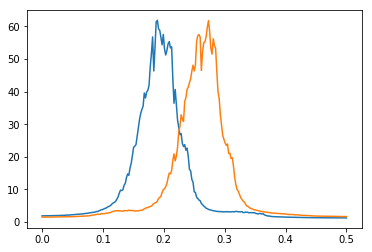

In [70]:
# 1024 mesh nodes, 100 segments
ffts_x = map(np.abs, map(np.fft.rfft, x.T.get()))
ffts_y = map(np.abs, map(np.fft.rfft, y.T.get()))

plt.plot(np.fft.rfftfreq(len(x)), np.sum(ffts_x, axis=0))
plt.plot(np.fft.rfftfreq(len(y)), np.sum(ffts_y, axis=0))

The spread matches the previously computed theoretical value of `dQ_x = 0.155 and dQ_y = 0.154` in both planes.

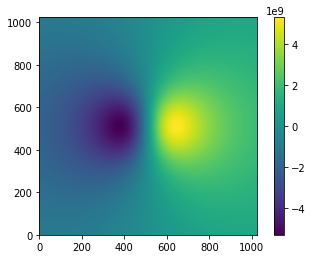

In [223]:
plt.imshow(frozen_sc_node_GPU.fields[0].get(), origin='lower', interpolation='None')
plt.colorbar()

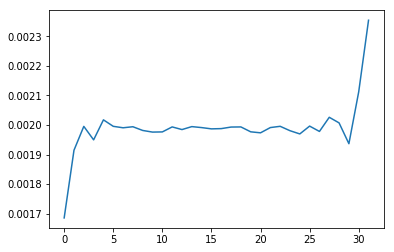

In [109]:
plt.plot(slices.sigma_y)

In [24]:
beam_GPU.x *= 4
beam_GPU.xp *= 4

In [59]:
frozen_sc_node_GPU.sigma_rtol = 0.2

In [17]:
with GPU(beam_GPU) as cmg:
    with Timer() as t:
        m_GPU.track(beam_GPU)

STORE centroid FFT! compare to 2.5D PIC...

### 2. 2.5D slice-by-slice self-consistent PIC

In [ ]:
mesh_3d = create_3dmesh_from_beam(beam, [n_mesh_nodes_pic]*2, [n_mesh_sigma_pic]*2, 
                                  slices=beam.get_slices(slicer_sc))

In [169]:
m_GPU = make_machine(100)
np.random.seed(42)
beam_GPU = make_beam(m_GPU)
assert (m_GPU.optics == 'smooth')
sc_integration_length = m_GPU.circumference / len(m_GPU.transverse_map)

poissonsolver = GPUFFTPoissonSolver_2_5D(mesh_3d, context=context, save_memory=False)
pypic_algorithm = PyPIC_GPU(mesh_3d, poissonsolver, context=context, 
                            memory_pool=memory_pool)
pic_sc_node = SpaceChargePIC(sc_integration_length, pypic_algorithm)

m_GPU.install_after_each_transverse_segment(pic_sc_node)

*** PyHEADTAIL WARNING! RFBucketMatcher: failed to converge with Brent method, continuing with Newton-Raphson method.


In [17]:
with GPU(beam_GPU) as cmg:
    with Timer() as t:
        m_GPU.track(beam_GPU)

In [18]:
print ('The one-turn map of {} segments took {:.3f} sec.'.format(
    len(m_GPU.transverse_map), t.interval))

The one-turn map of 100 segments took 2.497 sec.


In [18]:
x = gp.empty((512, 1024), dtype=np.float64)
y = gp.empty((512, 1024), dtype=np.float64)

In [19]:
with GPU(beam_GPU) as cmg:
    beam_GPU.sort_for('id')
    x[0,:] = beam_GPU.x[:x.shape[1]]
    y[0,:] = beam_GPU.y[:y.shape[1]]
    for turn in xrange(1, len(x)):
        m_GPU.track(beam_GPU)
        beam_GPU.sort_for('id')
        x[turn,:] = beam_GPU.x[:x.shape[1]]
        y[turn,:] = beam_GPU.y[:y.shape[1]]

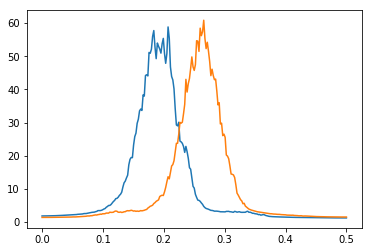

In [20]:
# 128 mesh nodes, 100 segments
ffts_x = map(np.abs, map(np.fft.rfft, x.T.get()))
ffts_y = map(np.abs, map(np.fft.rfft, y.T.get()))

plt.plot(np.fft.rfftfreq(len(x)), np.sum(ffts_x, axis=0))
plt.plot(np.fft.rfftfreq(len(y)), np.sum(ffts_y, axis=0))

#### Precision Influence

In [43]:
pic_sc_node.pic_dtype = np.float32

In [106]:
pic_sc_node.pic_dtype = np.float64

In [170]:
pic_sc_node.sort_particles = True

In [171]:
cmg = GPU(beam_GPU).__enter__()

In [172]:
beam_GPU.sort_for('id')
xp0, yp0 = beam_GPU.xp.copy(), beam_GPU.yp.copy()

In [173]:
%timeit pic_sc_node.track(beam_GPU)

100 loops, best of 3: 8.12 ms per loop


In [174]:
beam_GPU.sort_for('id')
xp1, yp1 = beam_GPU.xp.copy(), beam_GPU.yp.copy()

In [175]:
cmg.__exit__(None, None, None)

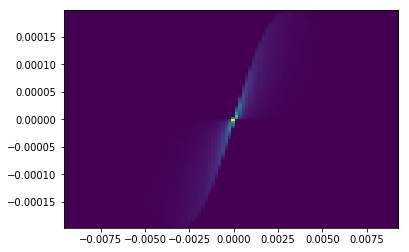

In [72]:
plt.hist2d(beam_GPU.x, (xp1 - xp0).get(), bins=100);

In [176]:
gp.sum(xp1 - xp0)

array(-2.8185787037671162e-14)

In [75]:
np.max(np.abs((xp1-xp0).get()))

0.00019818394329538174

In [112]:
beam_GPU.xp, beam_GPU.id

(array([  7.03262415e-05,  -2.84137838e-05,   9.20420436e-05, ...,
         -1.59709115e-05,   1.17050456e-04,   9.24976018e-05]),
 array([      1,       2,       3, ...,  999998,  999999, 1000000], dtype=int32))

In [120]:
beam_GPU.xp, beam_GPU.id

(array([  7.03262415e-05,  -2.84137838e-05,   9.20420436e-05, ...,
         -1.59709115e-05,   1.17052379e-04,   9.24976018e-05]),
 array([      1,       2,       3, ...,  999998,  999999, 1000000], dtype=int32))

In [122]:
xp1_sorted = xp1.copy()

In [129]:
xp1_fp64 = xp1.copy()

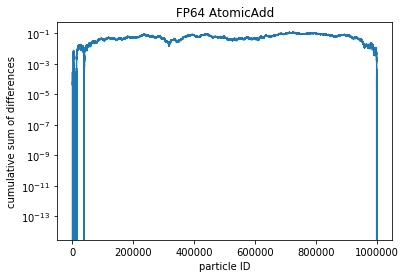

In [167]:
plt.plot(np.cumsum((xp1 - xp0).get()))
plt.yscale('log')
plt.title('FP64 AtomicAdd')
plt.xlabel('particle ID')
plt.ylabel('cumulative sum of differences');

$\implies$ for FP64 atomicAdd, the total centroid kick correctly adds up to $10^{-14}$ which is equivalent to zero within double precision error. 

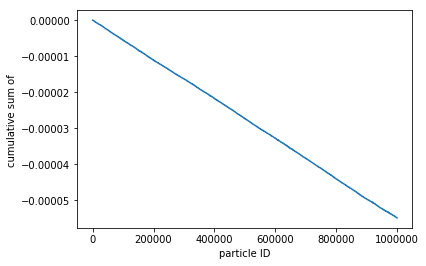

In [168]:
plt.plot(np.cumsum((xp1_fp64 - xp1_sorted).get()))
plt.ylabel('cumulative sum of ')
plt.xlabel('particle ID');

$\implies$ for the sorted algorithm, the total centroid kick adds up to $10^{-5}$ (which should be more around $10^{-14}$ as in the FP64 AtomicAdd case which we compare to here).

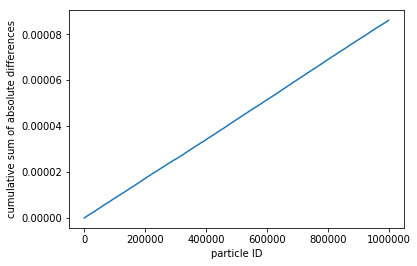

In [159]:
plt.plot(np.cumsum(np.abs((xp1_fp64 - xp1_sorted).get())))
plt.ylabel('cumulative sum of absolute differences')
plt.xlabel('particle ID');

$\implies$ each particle adds equally to the $10^{-5}$ total sum of the kicks, otherwise we would see a jump somewhere and not a smoothly monotonically increasing line.

$\implies$ i.e., the sorted algorithm has a systematic problem leading to a non-vanishing centroid kick which violates the third law of Newton (direct space charge should not have any influence on the centroid).

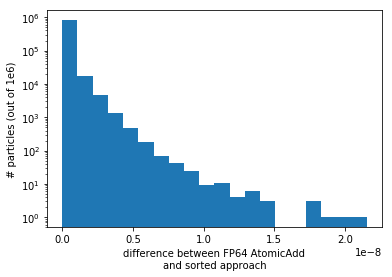

In [153]:
plt.hist(np.abs((xp1_fp64 - xp1_sorted).get())[np.abs((xp1_fp64 - xp1_sorted).get()) != 0], bins=20,)
plt.yscale('log')
plt.xlabel('difference between FP64 AtomicAdd\nand sorted approach')
plt.ylabel('# particles (out of 1e6)')

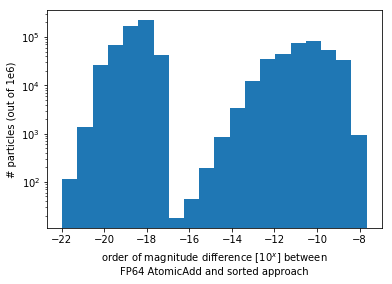

In [150]:
plt.hist(np.log10(np.abs((xp1_fp64 - xp1_sorted).get())[np.abs((xp1_fp64 - xp1_sorted).get()) != 0]), bins=20,)
plt.yscale('log')
plt.xlabel('order of magnitude difference [$10^x$] between\nFP64 AtomicAdd and sorted approach')
plt.ylabel('# particles (out of 1e6)')